In [1]:
%matplotlib inline # 其意义是将那些用于 matplotlib绘制的图显示在页面里而不是弹出一个窗口,因此就不需要plt.show()这一语句来显示图片
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

**1-5行** 主要是导出相应的包

## 3.2.1 生成数据集

In [4]:
num_inputs = 2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2
features = nd.random.normal(scale = 1, shape=(num_examples, num_inputs)) # 从正态（高斯）分布中抽取随机样本
labels = true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
labels += nd.random.normal(scale = 0.01,shape = labels.shape)

**第1行** num_inputs 输入的特征维度，代表x1，x2 

**第2行** num_examples 样本的个数 

**第3行** true_w 真实的权重值 

**第4行** true_b 真实的偏置值 

**第5行** features 从高斯分布中抽取样本

**第6-7行** labels 所有样本的标签 


In [5]:
features[0],labels[0] 
# 注意，features的每一行是一个长度为2的向量，
# 而labels的每一行是一个长度为1的向量（标量）

(
 [2.2122064 0.7740038]
 <NDArray 2 @cpu(0)>, 
 [6.000587]
 <NDArray 1 @cpu(0)>)

**第1行** 显示features和label的部分数据

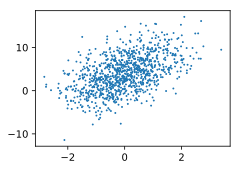

In [11]:
def use_svg_display():
    # y用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize']=figsize

set_figsize()
plt.scatter(features[:,0].asnumpy(),labels.asnumpy(),1); # 加分号只显示图
# plt.scatter(features[:,1].asnumpy(),labels.asnumpy(),1); # 加分号只显示图

**第1-3行** 定义user_svg_display,用矢量图显示。
**第5-8行** 定义set_figsize, 设置图的尺寸

## 3.2.2 读取数据

In [14]:
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    for i in range(0,num_examples,batch_size):
        j = nd.array(indices[i:min(i+batch_size,num_examples)])
        yield features.take(j),labels.take(j) # take函数根据索引返回对应元素

**第1行** 定义data_iter函数，每次返回batch_size(批量大小)个随机样本的特征和标签

**第2行** 计算features的长度num_examples

**第3行** **range()** 是一个函数，可以用来生成一个自然的序列；**list()** 方法用于将元组转换为列表；indices是index的复数

**第4行** **random.shuffle** 方法将序列的所有元素随机排序

**第5行** range(start,stop,step),

**第6行** 随机读取bacth_size个数，min()函数是为了防止越界

**第7行** yield [yield函数讲解](https://www.jianshu.com/p/d09778f4e055);take函数根据索引返回对应的元素

In [41]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[ 2.2122064   0.7740038 ]
 [-2.0710864  -0.08075491]
 [ 1.7660633   0.3360366 ]
 [-0.08512726 -0.90995044]
 [ 0.47648698 -0.19389465]
 [ 0.6538188   1.1236147 ]
 [ 0.8007321  -0.46828032]
 [ 0.35127962 -1.1684487 ]
 [ 0.24951884  0.52448374]
 [-1.8608177   1.3865626 ]]
<NDArray 10x2 @cpu(0)> 
[ 6.000587    0.34214625  6.5946956   7.1249194   5.8080363   1.6822191
  7.403495    8.883652    2.9193122  -4.2373376 ]
<NDArray 10 @cpu(0)>


## 3.2.3 初始化模型参数
将权值初始化成均值为0，标准差为0.01的正态随机数，偏差则初始化为0

In [34]:
w = nd.random.normal(scale=0.01,shape=(num_inputs,1))
b = nd.zeros(shape=(1,))
w,b

(
 [[0.00508696]
  [0.00915117]]
 <NDArray 2x1 @cpu(0)>, 
 [0.]
 <NDArray 1 @cpu(0)>)

**第1行** 用正态分布初始化w  
**第2行** 初始化b,shape=(1,)这里的逗号起到转换成元组类型的作用，更多逗号见[逗号的作用](https://blog.csdn.net/Love_wanling/article/details/81163915)，还可以学习[冒号和省略号的作用](https://blog.csdn.net/u013548568/article/details/78952264)

创建w,b的梯度

In [35]:
w.attach_grad()
b.attach_grad()

**第1-2行** 创建w,b他们的梯度

## 3.2.4 定义模型

In [37]:
def linreg(X,w,b):
    return nd.dot(X,w)+b

**第1-2行** 线性回归矢量计算表达式的实现，dot函数是点乘

## 3.2.5 定义损失函数

In [38]:
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape)) ** 2/2

**第1-2行** 定义损失函数，****** 是平方

## 3.2.6 定义优化算法

In [39]:
def sgd(params, lr, batch_size):  
    for param in params:
        param[:] = param - lr * param.grad / batch_size

**第1-2行** 是定义优化函数，这里应该是梯度下降更新参数 lr--学习率；param-更新的参数；batch_size--批量的大小；

## 3.2.7 训练模型 

In [42]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.040837
epoch 2, loss 0.000155
epoch 3, loss 0.000051


In [44]:
true_w,w

([2, -3.4], 
 [[ 1.9996815]
  [-3.3993795]]
 <NDArray 2x1 @cpu(0)>)

In [45]:
true_b,b

(4.2, 
 [4.1993194]
 <NDArray 1 @cpu(0)>)

## 3.2.8 小结

可以看出，仅使用NDArray和autograd模块就可以很容易地实现一个模型

## 3.2.9 练习

**1.为什么squared_loss函数中需要使用reshape?**  
因为y_hat是二维的，第二个维度的个数为1，而label值y是一维的，y_hat之所以是二维的是因为X是二维的，dot出来的值一定是二维的

**2.如果样本个数不能被批量大小整除，data_iter函数有什么变化？**  
data_iter函数最后会一个batch返回的样本个数不是batch_size个，而是不足batch_size个，如1000个样本，batch_size=9,最后一个batch样本个数是9个